In [1]:
import numpy as np
import pandas as pd

In [2]:
combined_df = pd.read_csv('../combined_df.csv')

In [3]:
from sklearn.model_selection import train_test_split

X = combined_df.drop(['subreddit', 'post'],  axis=1)  # Features
y = combined_df['subreddit']  # Target

In [4]:
# Print count of each class
print(y.value_counts())

subreddit
depression       117331
suicidewatch      66161
anxiety           57671
adhd              45631
bpd               24294
lonely            23635
autism             8869
schizophrenia      8712
ptsd               8643
addiction          7641
alcoholism         5911
Name: count, dtype: int64


In [5]:
# Oversample this data for better results
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)



In [6]:
# Print count of each class
print(y.value_counts())

subreddit
adhd             117331
autism           117331
ptsd             117331
suicidewatch     117331
lonely           117331
alcoholism       117331
schizophrenia    117331
depression       117331
addiction        117331
anxiety          117331
bpd              117331
Name: count, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X  , y, test_size=0.2, random_state=42)

# Convert X_train and X_test to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded)  # Convert to one-hot encoding


In [10]:

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='tanh'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape X_train to fit the Conv1D input shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model
model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on the test set
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)

Epoch 1/10
12907/12907 [==============================] - 47s 4ms/step - loss: 1.0671 - accuracy: 0.6504 - val_loss: 0.9824 - val_accuracy: 0.6752
Epoch 2/10
12907/12907 [==============================] - 45s 4ms/step - loss: 0.9193 - accuracy: 0.6968 - val_loss: 0.8740 - val_accuracy: 0.7101
Epoch 3/10
12907/12907 [==============================] - 63s 5ms/step - loss: 0.8232 - accuracy: 0.7286 - val_loss: 0.8071 - val_accuracy: 0.7354
Epoch 4/10
12907/12907 [==============================] - 66s 5ms/step - loss: 0.7504 - accuracy: 0.7523 - val_loss: 0.7717 - val_accuracy: 0.7464
Epoch 5/10
12907/12907 [==============================] - 56s 4ms/step - loss: 0.7004 - accuracy: 0.7681 - val_loss: 0.7086 - val_accuracy: 0.7676
Epoch 6/10
12907/12907 [==============================] - 59s 5ms/step - loss: 0.6584 - accuracy: 0.7817 - val_loss: 0.6816 - val_accuracy: 0.7783
Epoch 7/10
12907/12907 [==============================] - 53s 4ms/step - loss: 0.6255 - accuracy: 0.7918 - val_loss: 0

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.6685378241112002
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79     23566
           1       0.74      0.73      0.73     23355
           2       0.83      0.85      0.84     23341
           3       0.69      0.72      0.71     23431
           4       0.55      0.72      0.62     23377
           5       0.79      0.55      0.65     23453
           6       0.57      0.32      0.41     23301
           7       0.66      0.69      0.68     23667
           8       0.80      0.69      0.74     23555
           9       0.49      0.64      0.55     23666
          10       0.55      0.71      0.62     23417

    accuracy                           0.67    258129
   macro avg       0.68      0.67      0.67    258129
weighted avg       0.68      0.67      0.67    258129



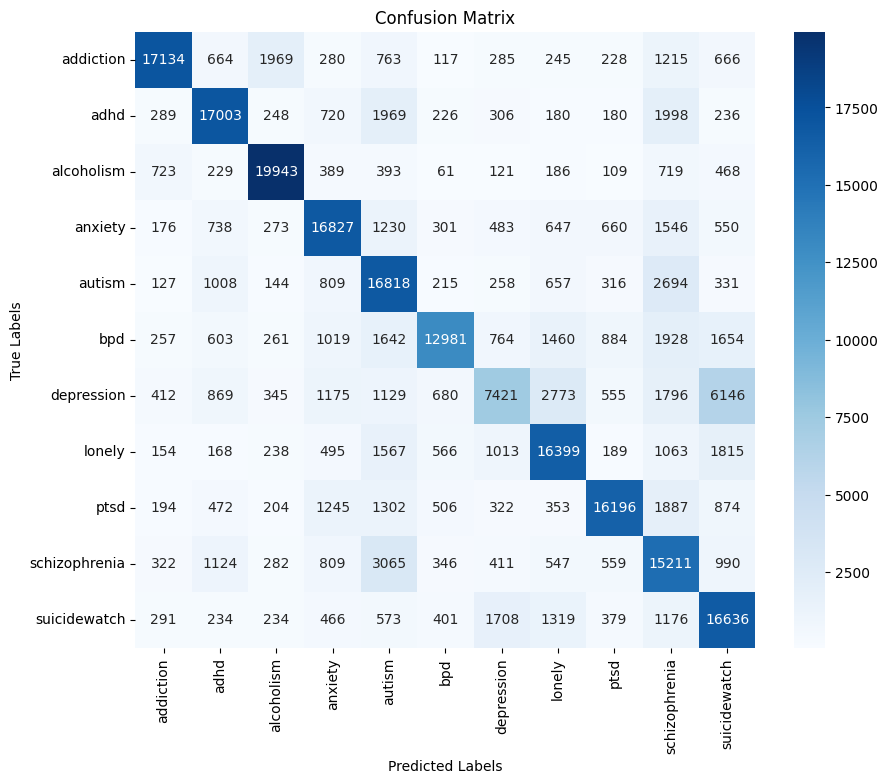

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have predictions in y_pred_classes and the true labels in y_test_encoded

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
